In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

import itertools

from pmdarima import auto_arima

from pandas.tseries.offsets import DateOffset
 
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Microsoft_Stock.csv', parse_dates = ['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012


# Checking stationarity

In [3]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [4]:
adfuller_test(df['Close'])

ADF Test Statistic : 1.7371362899270972
p-value : 0.9982158366942122
#Lags Used : 24
Number of Observations Used : 1486
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


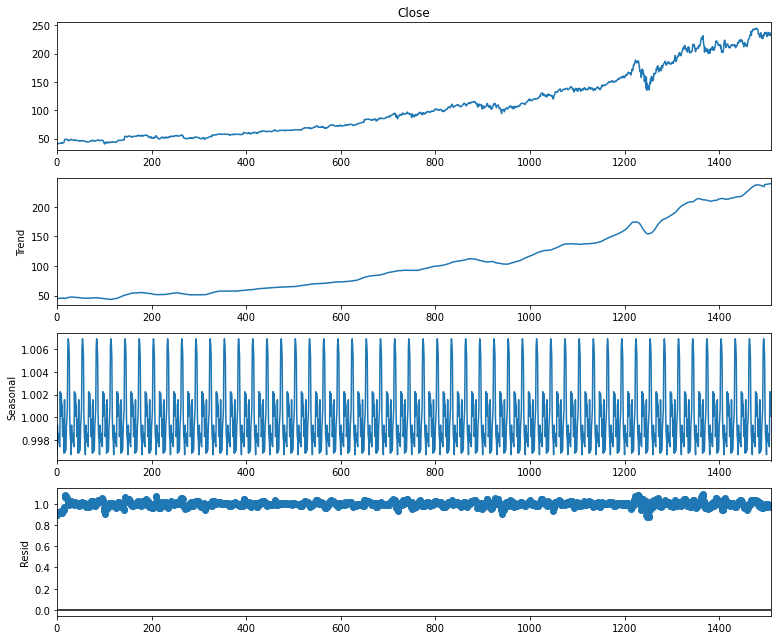

In [7]:
rcParams['figure.figsize'] = 11, 9
result = seasonal_decompose(df['Close'], model='multiplicative',extrapolate_trend='freq', period = 30)
result.plot()
plt.show()

# Making  time series stationary & finding value of d

In [4]:
df2 = df.copy()

In [5]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [16]:
df2['1st_Differencing_Close'] = list(df2['Close'] - df2['Close'].shift(1).fillna(method='bfill'))
df2['Seasonal_Differencing_Close'] = list((df2['Close'] - df2['Close'].shift(30).fillna(method='bfill')))
df2

,Open,High,Low,Close,Volume,1st_Differencing_Close,Seasonal_Differencing_Close
Date,,,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322,0.00,0.00
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476,-0.43,-0.43
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692,1.26,0.83
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375,-0.02,0.81
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438,-0.11,0.70
...,...,...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853,-3.12,-10.48
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853,4.14,-8.01
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455,-1.24,-9.75


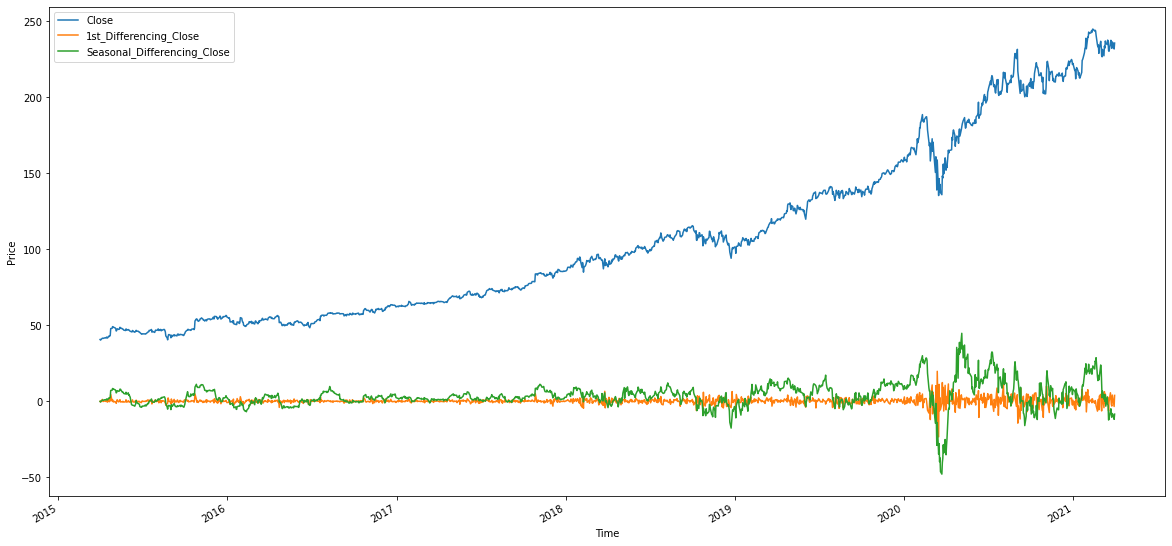

In [17]:
df2[['Close', '1st_Differencing_Close', 'Seasonal_Differencing_Close']].plot(figsize = (20, 10))
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [19]:
adfuller_test(df2['1st_Differencing_Close'])

ADF Test Statistic : -10.043852364231798
p-value : 1.472030729039075e-17
#Lags Used : 24
Number of Observations Used : 1486
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [20]:
adfuller_test(df2['Seasonal_Differencing_Close'])

ADF Test Statistic : -8.244431771082791
p-value : 5.603515444064056e-13
#Lags Used : 18
Number of Observations Used : 1492
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Both 1st diff & seasonal diff are stationary. But 1st diff has much lower p-value as compared to seasonal. So we will take d = 1

# Train test split

In [6]:
split = int(len(df2)*0.8)
train = df2[:split]
test = df2[split:]

In [7]:
train_data = train['Close']
train_data 

Date
2015-04-01 16:00:00     40.72
2015-04-02 16:00:00     40.29
2015-04-06 16:00:00     41.55
2015-04-07 16:00:00     41.53
2015-04-08 16:00:00     41.42
                        ...  
2020-01-10 16:00:00    161.34
2020-01-13 16:00:00    163.28
2020-01-14 16:00:00    162.13
2020-01-15 16:00:00    163.18
2020-01-16 16:00:00    166.17
Name: Close, Length: 1208, dtype: float64

In [8]:
test_data = test['Close']
test_data

Date
2020-01-17 16:00:00    167.10
2020-01-21 16:00:00    166.50
2020-01-22 16:00:00    165.70
2020-01-23 16:00:00    166.72
2020-01-24 16:00:00    165.04
                        ...  
2021-03-25 16:00:00    232.34
2021-03-26 16:00:00    236.48
2021-03-29 16:00:00    235.24
2021-03-30 16:00:00    231.85
2021-03-31 16:00:00    235.77
Name: Close, Length: 303, dtype: float64

# Finding the p, q

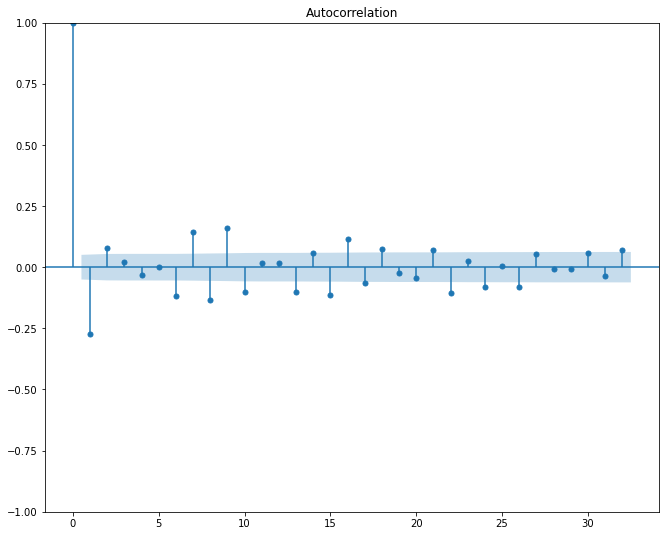

In [26]:
rcParams['figure.figsize'] = 11, 9
acf = plot_acf(df2['1st_Differencing_Close'].dropna()) #q

In [27]:
a = pd.Series(df2['1st_Differencing_Close'])
for i in range(5):
    print(a.autocorr(lag=i))

1.0
-0.2746931718664349
0.07695067695643802
0.022529404929098884
-0.03102969412854769


Without considering the 0th lag, the max lag in terms of magnitude occurs at 1st lag. We can also take 2nd lag since its outside the confidence interval. So q = 1 or q = 2.

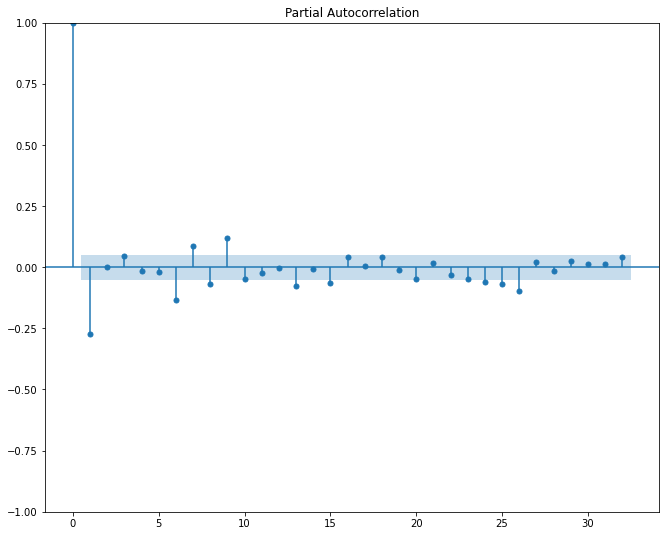

In [28]:
rcParams['figure.figsize'] = 11, 9
pacf = plot_pacf(df2['1st_Differencing_Close'].dropna()) #p

The first lag is well outside the confidence interval. So p = 1.

# Using ARIMA

In [35]:
model = ARIMA(df2['Close'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3381.104
Date:                Thu, 26 Jan 2023   AIC                           6768.207
Time:                        11:23:09   BIC                           6784.167
Sample:                             0   HQIC                          6774.151
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2885      0.037     -7.781      0.000      -0.361      -0.216
ma.L1          0.0189      0.040      0.476      0.634      -0.059       0.097
sigma2         5.1570      0.075     68.924      0.0

In [36]:
pred = model_fit.predict(start= len(train_data), end = len(train_data) + len(test_data) - 1, dynamic=True)
pred = pred.tolist()

<AxesSubplot:xlabel='Date'>

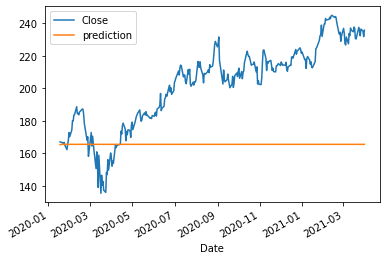

In [37]:
df_arima=pd.DataFrame(test_data)
df_arima["prediction"] = pd.Series(pred, index = test_data.index)
df_arima.plot()

The predicted values are straight line. We will increase the order of differencing. d = 2

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -3379.277
Date:                Thu, 26 Jan 2023   AIC                           6764.554
Time:                        11:24:08   BIC                           6780.512
Sample:                             0   HQIC                          6770.497
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2746      0.010    -28.738      0.000      -0.293      -0.256
ma.L1         -0.9986      0.002   -563.811      0.000      -1.002      -0.995
sigma2         5.1382      0.076     67.756      0.0

<AxesSubplot:xlabel='Date'>

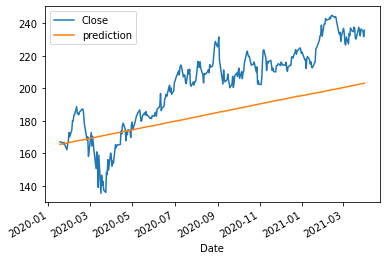

In [38]:
model = ARIMA(df2['Close'], order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

pred = model_fit.predict(start= len(train_data), end = len(train_data) + len(test_data) - 1, dynamic=True)
pred = pred.tolist()

df_arima=pd.DataFrame(test_data)
df_arima["prediction"] = pred
df_arima.plot()

As we can see our model has captured trend but it does not capture seasonality.

# Using SARIMAX

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series. If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR(P) or SMA(Q) terms if your model has seasonal components

In [26]:
# Seasonal - fit stepwise auto-ARIMA
#here we will keep only P.

smodel = auto_arima(df2['Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True, stationary = False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9731.427, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7424.527, Time=1.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8611.001, Time=1.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9819.716, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7730.700, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7202.381, Time=4.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.13 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9610.810, Time=3.98 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=7123.710, Time=6.21 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=7355.902, Time=3.05 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.53 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.37 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1511
Model:             SARIMAX(2, 0, 3)x(2, 1, [], 12)   Log Likelihood               -3531.083
Date:                             Thu, 26 Jan 2023   AIC                           7080.166
Time:                                     11:19:15   BIC                           7127.979
Sample:                                          0   HQIC                          7097.979
                                            - 1511                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2258      0.124      1.814      0.070      -0.018       0.470
ar.L1          0.0083      0.012      0.716      0.474      -0.015       0.031
ar.L2          0.8705      0.011     81.049      0.000       0.849       0.892
ma.L1          0.7286      0.015     47.107      0.000       0.698       0.759
ma.L2         -0.0894      0.022     -4.080      0.000      -0.132      -0.046
ma.L3          0.1676      0.016     10.381      0.000       0.136       0.199
ar.S.L12      -0.6227      0.014    -45.189      0.000      -0.650      -0.596
ar.S.L24      -0.3722      0.014    -25.903      0.000      -0.400      -0.344
sigma2         6.5169      0.111     58.827      0.000       6.300       6.734
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4298.63
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              20.97   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
model2 = SARIMAX(df2['Close'], order=(2,0,3),seasonal_order =(2,1,0,12))
model_fit2= model2.fit()
df2['prediction'] = model_fit2.predict(start= len(train_data) , end = len(train_data) + len(test_data) - 1)


In [144]:
df2

,Open,High,Low,Close,Volume,prediction
Date,,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322,NaN
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476,NaN
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692,NaN
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375,NaN
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438,NaN
...,...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853,237.849318
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853,233.183275
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455,235.549107


<AxesSubplot:xlabel='Date'>

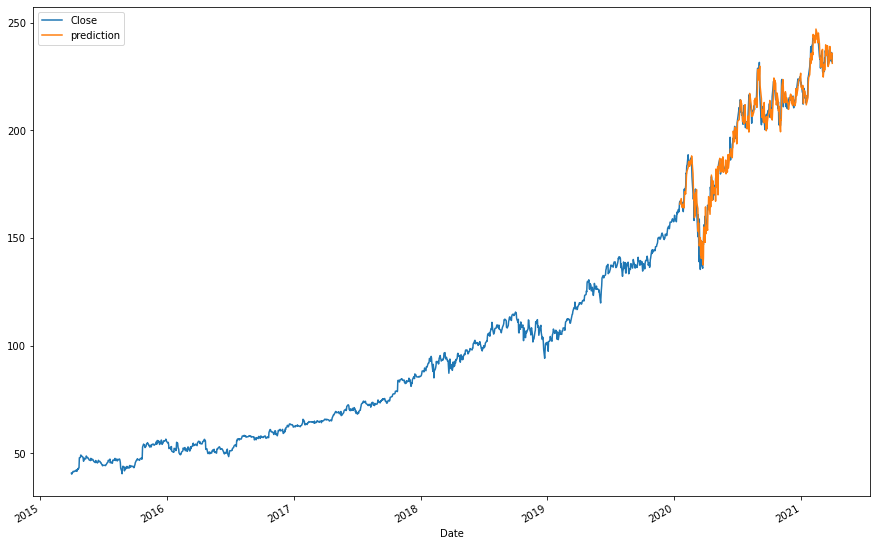

In [129]:
df2[['Close', 'prediction']].plot(figsize = (15, 10))

In [130]:
r2_score(df2['Close'][split:], df2['prediction'][split:])

0.9629438503525336

# Predicting the future using SARIMAX 

In [100]:
future_dates = [df_sarimax.index[-1] + DateOffset(i) for i in range(365)]
future_dates

[Timestamp('2021-03-31 16:00:00'),
 Timestamp('2021-04-01 16:00:00'),
 Timestamp('2021-04-02 16:00:00'),
 Timestamp('2021-04-03 16:00:00'),
 Timestamp('2021-04-04 16:00:00'),
 Timestamp('2021-04-05 16:00:00'),
 Timestamp('2021-04-06 16:00:00'),
 Timestamp('2021-04-07 16:00:00'),
 Timestamp('2021-04-08 16:00:00'),
 Timestamp('2021-04-09 16:00:00'),
 Timestamp('2021-04-10 16:00:00'),
 Timestamp('2021-04-11 16:00:00'),
 Timestamp('2021-04-12 16:00:00'),
 Timestamp('2021-04-13 16:00:00'),
 Timestamp('2021-04-14 16:00:00'),
 Timestamp('2021-04-15 16:00:00'),
 Timestamp('2021-04-16 16:00:00'),
 Timestamp('2021-04-17 16:00:00'),
 Timestamp('2021-04-18 16:00:00'),
 Timestamp('2021-04-19 16:00:00'),
 Timestamp('2021-04-20 16:00:00'),
 Timestamp('2021-04-21 16:00:00'),
 Timestamp('2021-04-22 16:00:00'),
 Timestamp('2021-04-23 16:00:00'),
 Timestamp('2021-04-24 16:00:00'),
 Timestamp('2021-04-25 16:00:00'),
 Timestamp('2021-04-26 16:00:00'),
 Timestamp('2021-04-27 16:00:00'),
 Timestamp('2021-04-

In [135]:
df_future = pd.DataFrame({'Open':[np.nan for i in range(len(future_dates))], 
                          'High':[np.nan for i in range(len(future_dates))],
                          'Low':[np.nan for i in range(len(future_dates))], 
                          'Close':[np.nan for i in range(len(future_dates))], 
                          'Volume':[np.nan for i in range(len(future_dates))],
                          'prediction':[np.nan for i in range(len(future_dates))]}, index = future_dates)
df_future

,Open,High,Low,Close,Volume,prediction
2021-03-31 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-03 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-04 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-03-26 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
df_new = pd.concat([df2, df_future], axis = 0)
df_new

,Open,High,Low,Close,Volume,prediction
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322.0,NaN
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476.0,NaN
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692.0,NaN
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375.0,NaN
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438.0,NaN
...,...,...,...,...,...,...
2022-03-26 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-28 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
model2 = SARIMAX(df_new['Close'], order=(2,0,3),seasonal_order =(2,1,0,12))
model_fit2= model2.fit()
df_new['prediction'] = model_fit2.predict(start= len(df2))

#df_final[['Close', 'prediction']].plot(figsize=(12,8))
df_new

,Open,High,Low,Close,Volume,prediction
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322.0,NaN
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476.0,NaN
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692.0,NaN
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375.0,NaN
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438.0,NaN
...,...,...,...,...,...,...
2022-03-26 16:00:00,NaN,NaN,NaN,NaN,NaN,236.031611
2022-03-27 16:00:00,NaN,NaN,NaN,NaN,NaN,236.689185
2022-03-28 16:00:00,NaN,NaN,NaN,NaN,NaN,233.623469
2022-03-29 16:00:00,NaN,NaN,NaN,NaN,NaN,230.967258


In [141]:
df_new['prediction']

2015-04-01 16:00:00   NaN
2015-04-02 16:00:00   NaN
2015-04-06 16:00:00   NaN
2015-04-07 16:00:00   NaN
2015-04-08 16:00:00   NaN
                       ..
2022-03-26 16:00:00   NaN
2022-03-27 16:00:00   NaN
2022-03-28 16:00:00   NaN
2022-03-29 16:00:00   NaN
2022-03-30 16:00:00   NaN
Name: prediction, Length: 1876, dtype: float64

<AxesSubplot:>

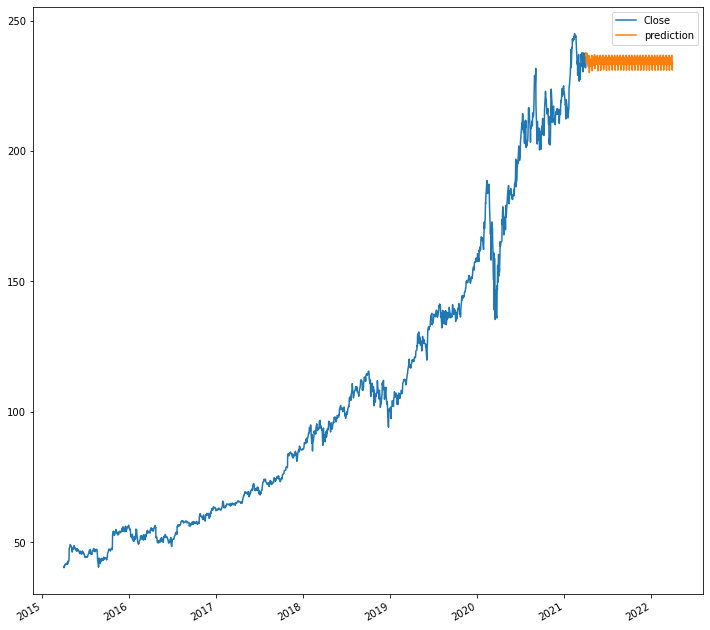

In [148]:
df_new[['Close', 'prediction']].plot(figsize=(12,12))